# Teleseismic synthetic example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import swspy
import numpy as np
import os, sys
import matplotlib 
import matplotlib.pyplot as plt
from scipy import signal
import obspy
%matplotlib notebook
import time


### 0. Specify whether want to recreate synthetics, or use existing ones:

(Use existing ones for exact reproducability due to randomness of noise)

In [3]:
create_synthetics = True

### 1. Create source-time function:

<IPython.core.display.Javascript object>


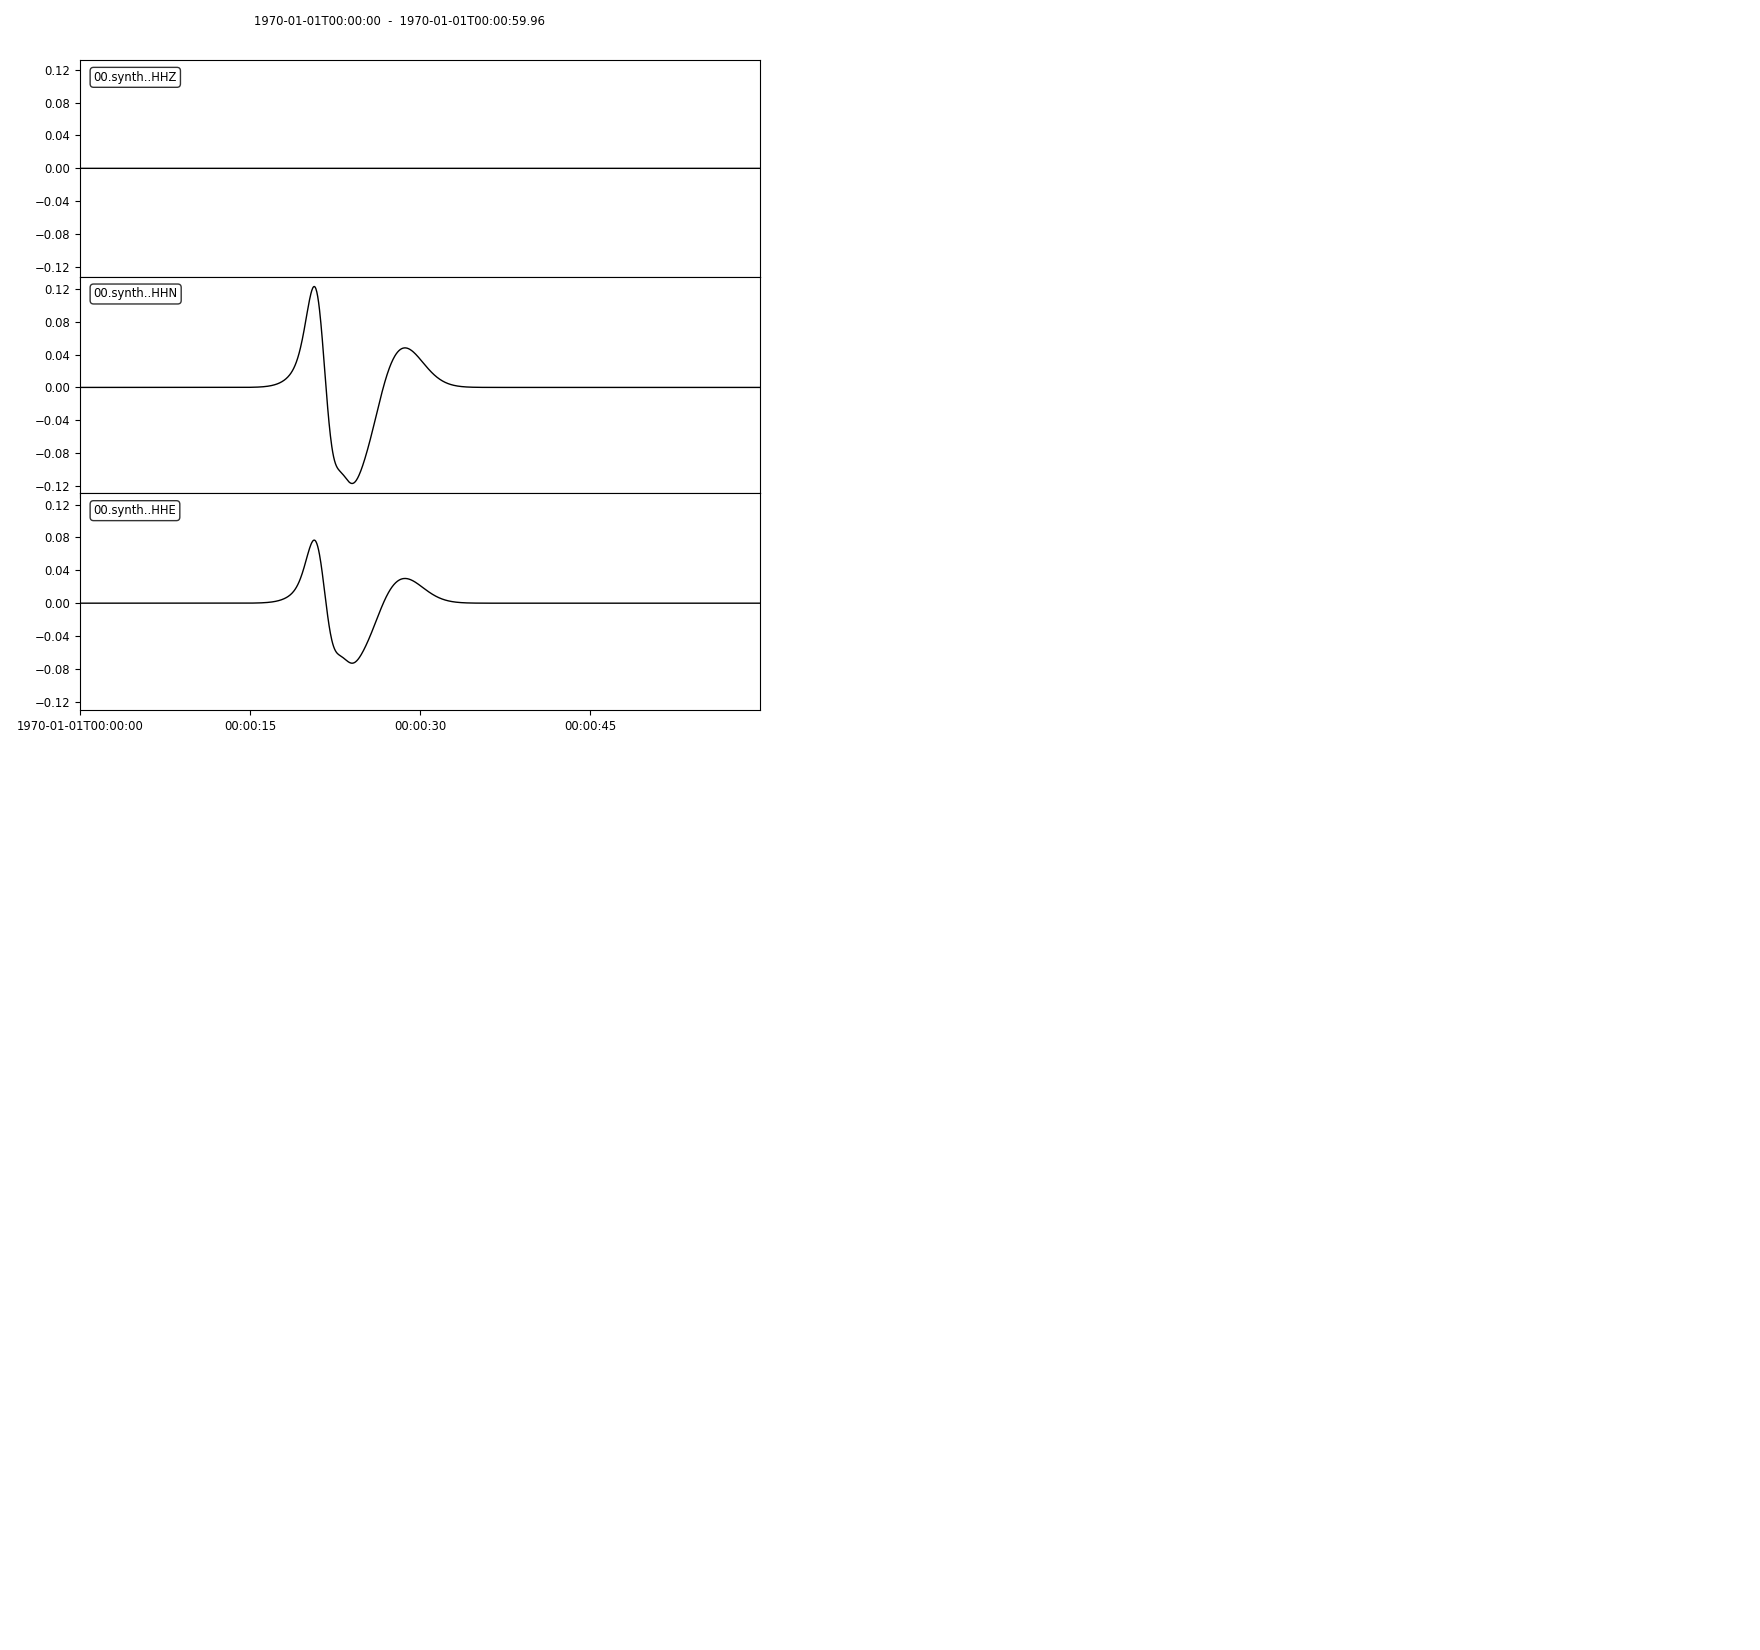

<IPython.core.display.Javascript object>


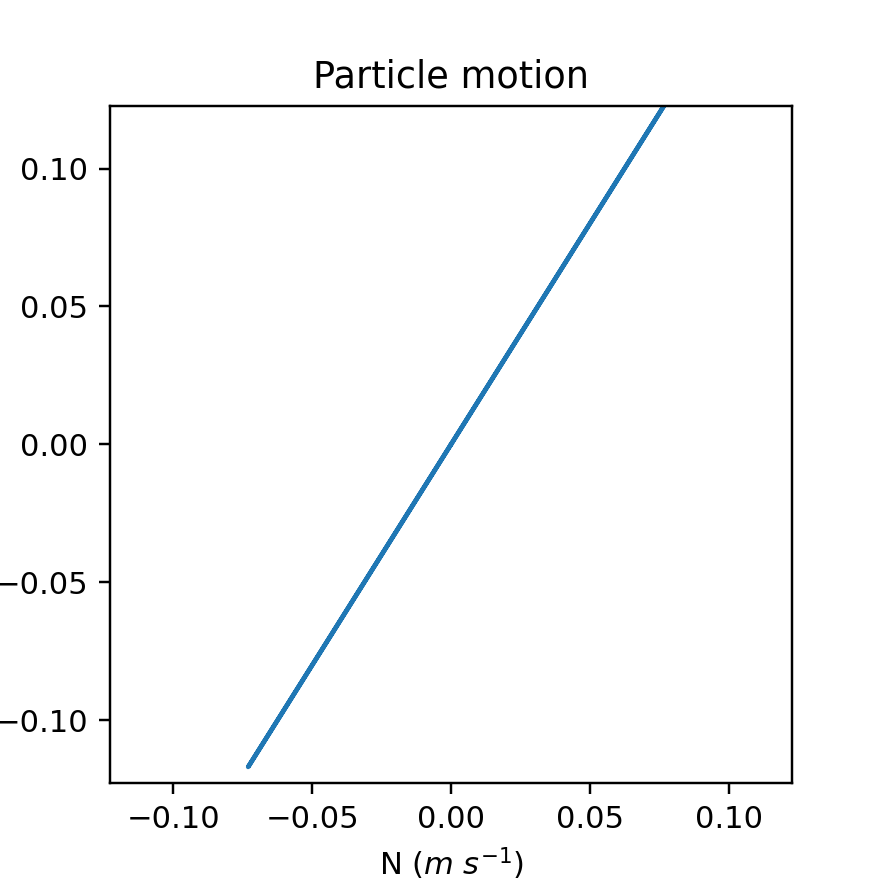

In [4]:
# Create source-time function:
t_src = 25.0
src_pol_from_N = 212.0
src_dur = 60.
fs = 25 #50 #25 #100 
src_freq = 1.0 #0.1
if create_synthetics:
    ZNE_st1 = swspy.splitting.forward_model.create_src_time_func(src_dur, fs, src_pol_from_N=src_pol_from_N, src_pol_from_up=0, src_freq=src_freq, t_src=t_src)
    ZNE_st2 = swspy.splitting.forward_model.create_src_time_func(src_dur, fs, src_pol_from_N=src_pol_from_N, src_pol_from_up=0, src_freq=src_freq*1.2, t_src=t_src-1)
    ZNE_st3 = swspy.splitting.forward_model.create_src_time_func(src_dur, fs, src_pol_from_N=src_pol_from_N, src_pol_from_up=0, src_freq=src_freq*1.4, t_src=t_src-2)
    ZNE_st4 = swspy.splitting.forward_model.create_src_time_func(src_dur, fs, src_pol_from_N=src_pol_from_N, src_pol_from_up=0, src_freq=src_freq*1.6, t_src=t_src-3)
    ZNE_st = ZNE_st1.copy()
    for i in range(len(ZNE_st1)):
        ZNE_st[i].data = ZNE_st1[i].data + 0.5*ZNE_st2[i].data + 0.5*ZNE_st3[i].data + 0.5*ZNE_st4[i].data
        
else:
    ZNE_st = obspy.read(os.path.join("data", "teleseismic_ZNE_st.mseed"))
ZNE_st.plot()

plt.figure(figsize=(4,4))
plt.plot(ZNE_st.select(channel="??E")[0].data, ZNE_st.select(channel="??N")[0].data)
abs_max_tmp = np.max(np.array([np.max(np.abs(ZNE_st.select(channel="??N")[0].data)), np.max(np.abs(ZNE_st.select(channel="??E")[0].data))]))
plt.xlim([-abs_max_tmp, abs_max_tmp])
plt.ylim([-abs_max_tmp, abs_max_tmp])
plt.title("Particle motion")
plt.xlabel("E ($m$ $s^{-1}$)")
plt.xlabel("N ($m$ $s^{-1}$)")
plt.show()


### 2. Apply a layer of splitting:

In [5]:
# Define SNR:
snr = 1000 #100 #1000 #100 # SNR of the src time func (applied so that get non-zero eigenvalue ratio for multi-layer splitting)


<IPython.core.display.Javascript object>


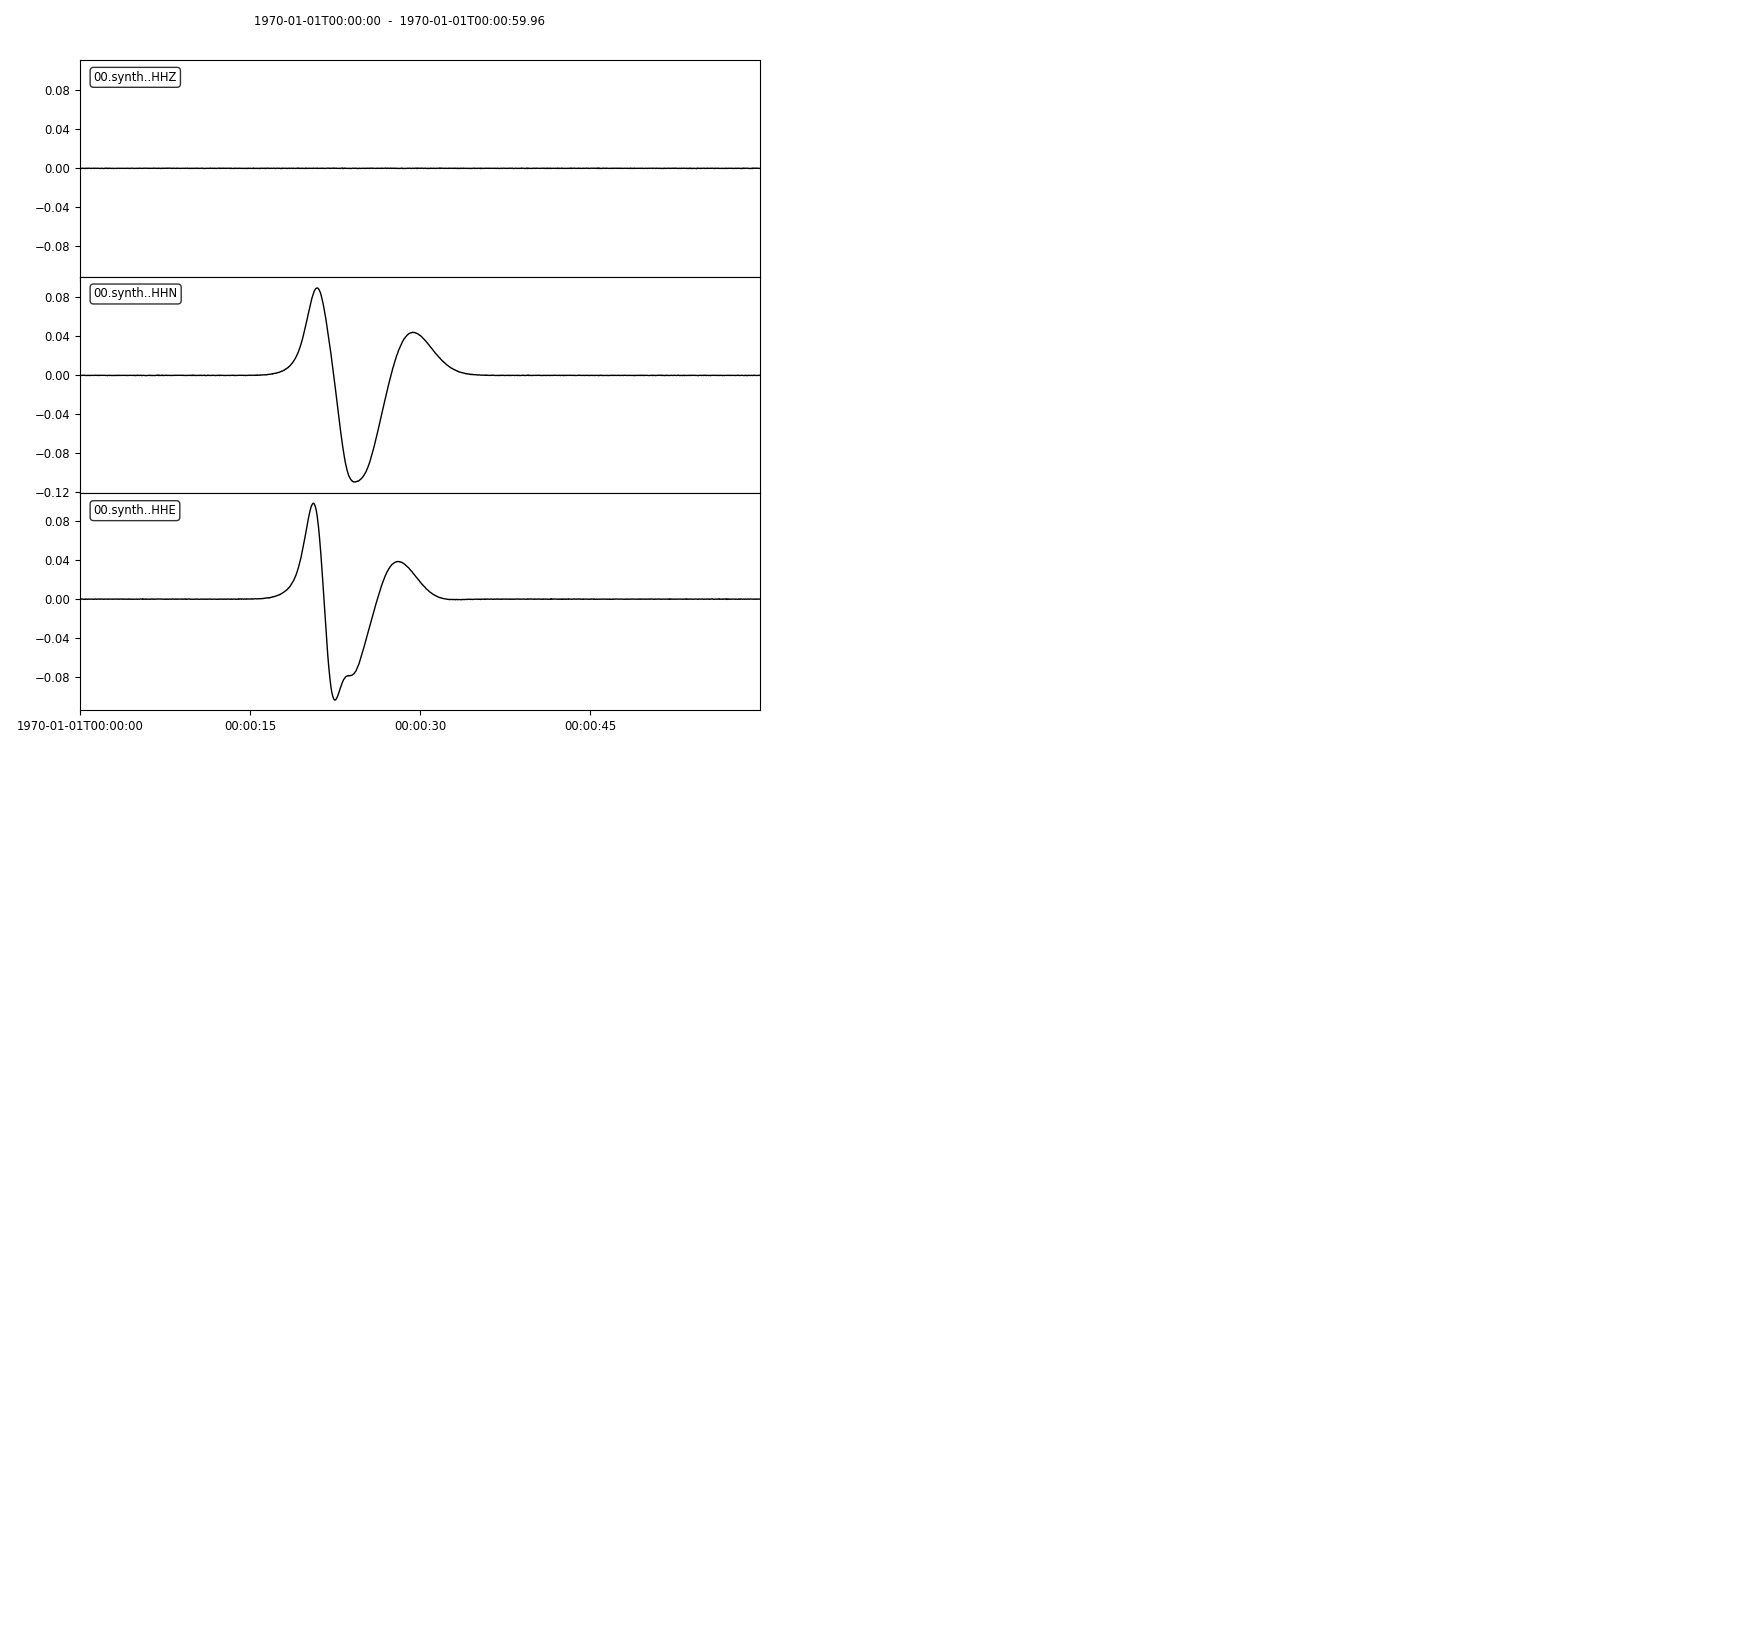

<IPython.core.display.Javascript object>


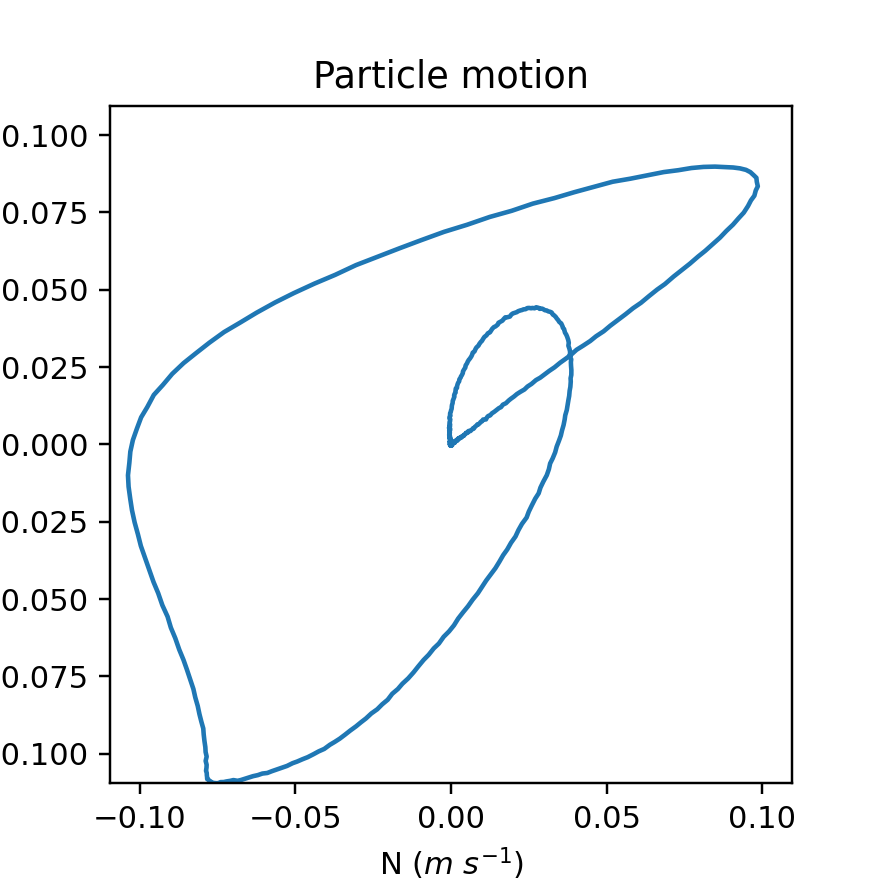

In [6]:
# Specify layer anisotropy parameters:
phi_from_N = 60.
dt = 1.25 #1.5 #1.25 #1.3
back_azi = 0
event_inclin_angle_at_station = 0

# Apply splitting:
if create_synthetics:
    ZNE_st_layer1 = swspy.splitting.forward_model.add_splitting(ZNE_st, phi_from_N, dt, back_azi, event_inclin_angle_at_station, snr=snr)
else:
    ZNE_st_layer1 = obspy.read(os.path.join("data", "teleseismic_ZNE_st_layer1.mseed"))
ZNE_st_layer1.plot()

plt.figure(figsize=(4,4))
plt.plot(ZNE_st_layer1.select(channel="??E")[0].data, ZNE_st_layer1.select(channel="??N")[0].data)
abs_max_tmp = np.max(np.array([np.max(np.abs(ZNE_st_layer1.select(channel="??N")[0].data)), np.max(np.abs(ZNE_st_layer1.select(channel="??E")[0].data))]))
plt.xlim([-abs_max_tmp, abs_max_tmp])
plt.ylim([-abs_max_tmp, abs_max_tmp])
plt.title("Particle motion")
plt.xlabel("E ($m$ $s^{-1}$)")
plt.xlabel("N ($m$ $s^{-1}$)")
plt.show()


### 3. Measure splitting on single layer:

Time taken (s): 11.645301103591919


<IPython.core.display.Javascript object>


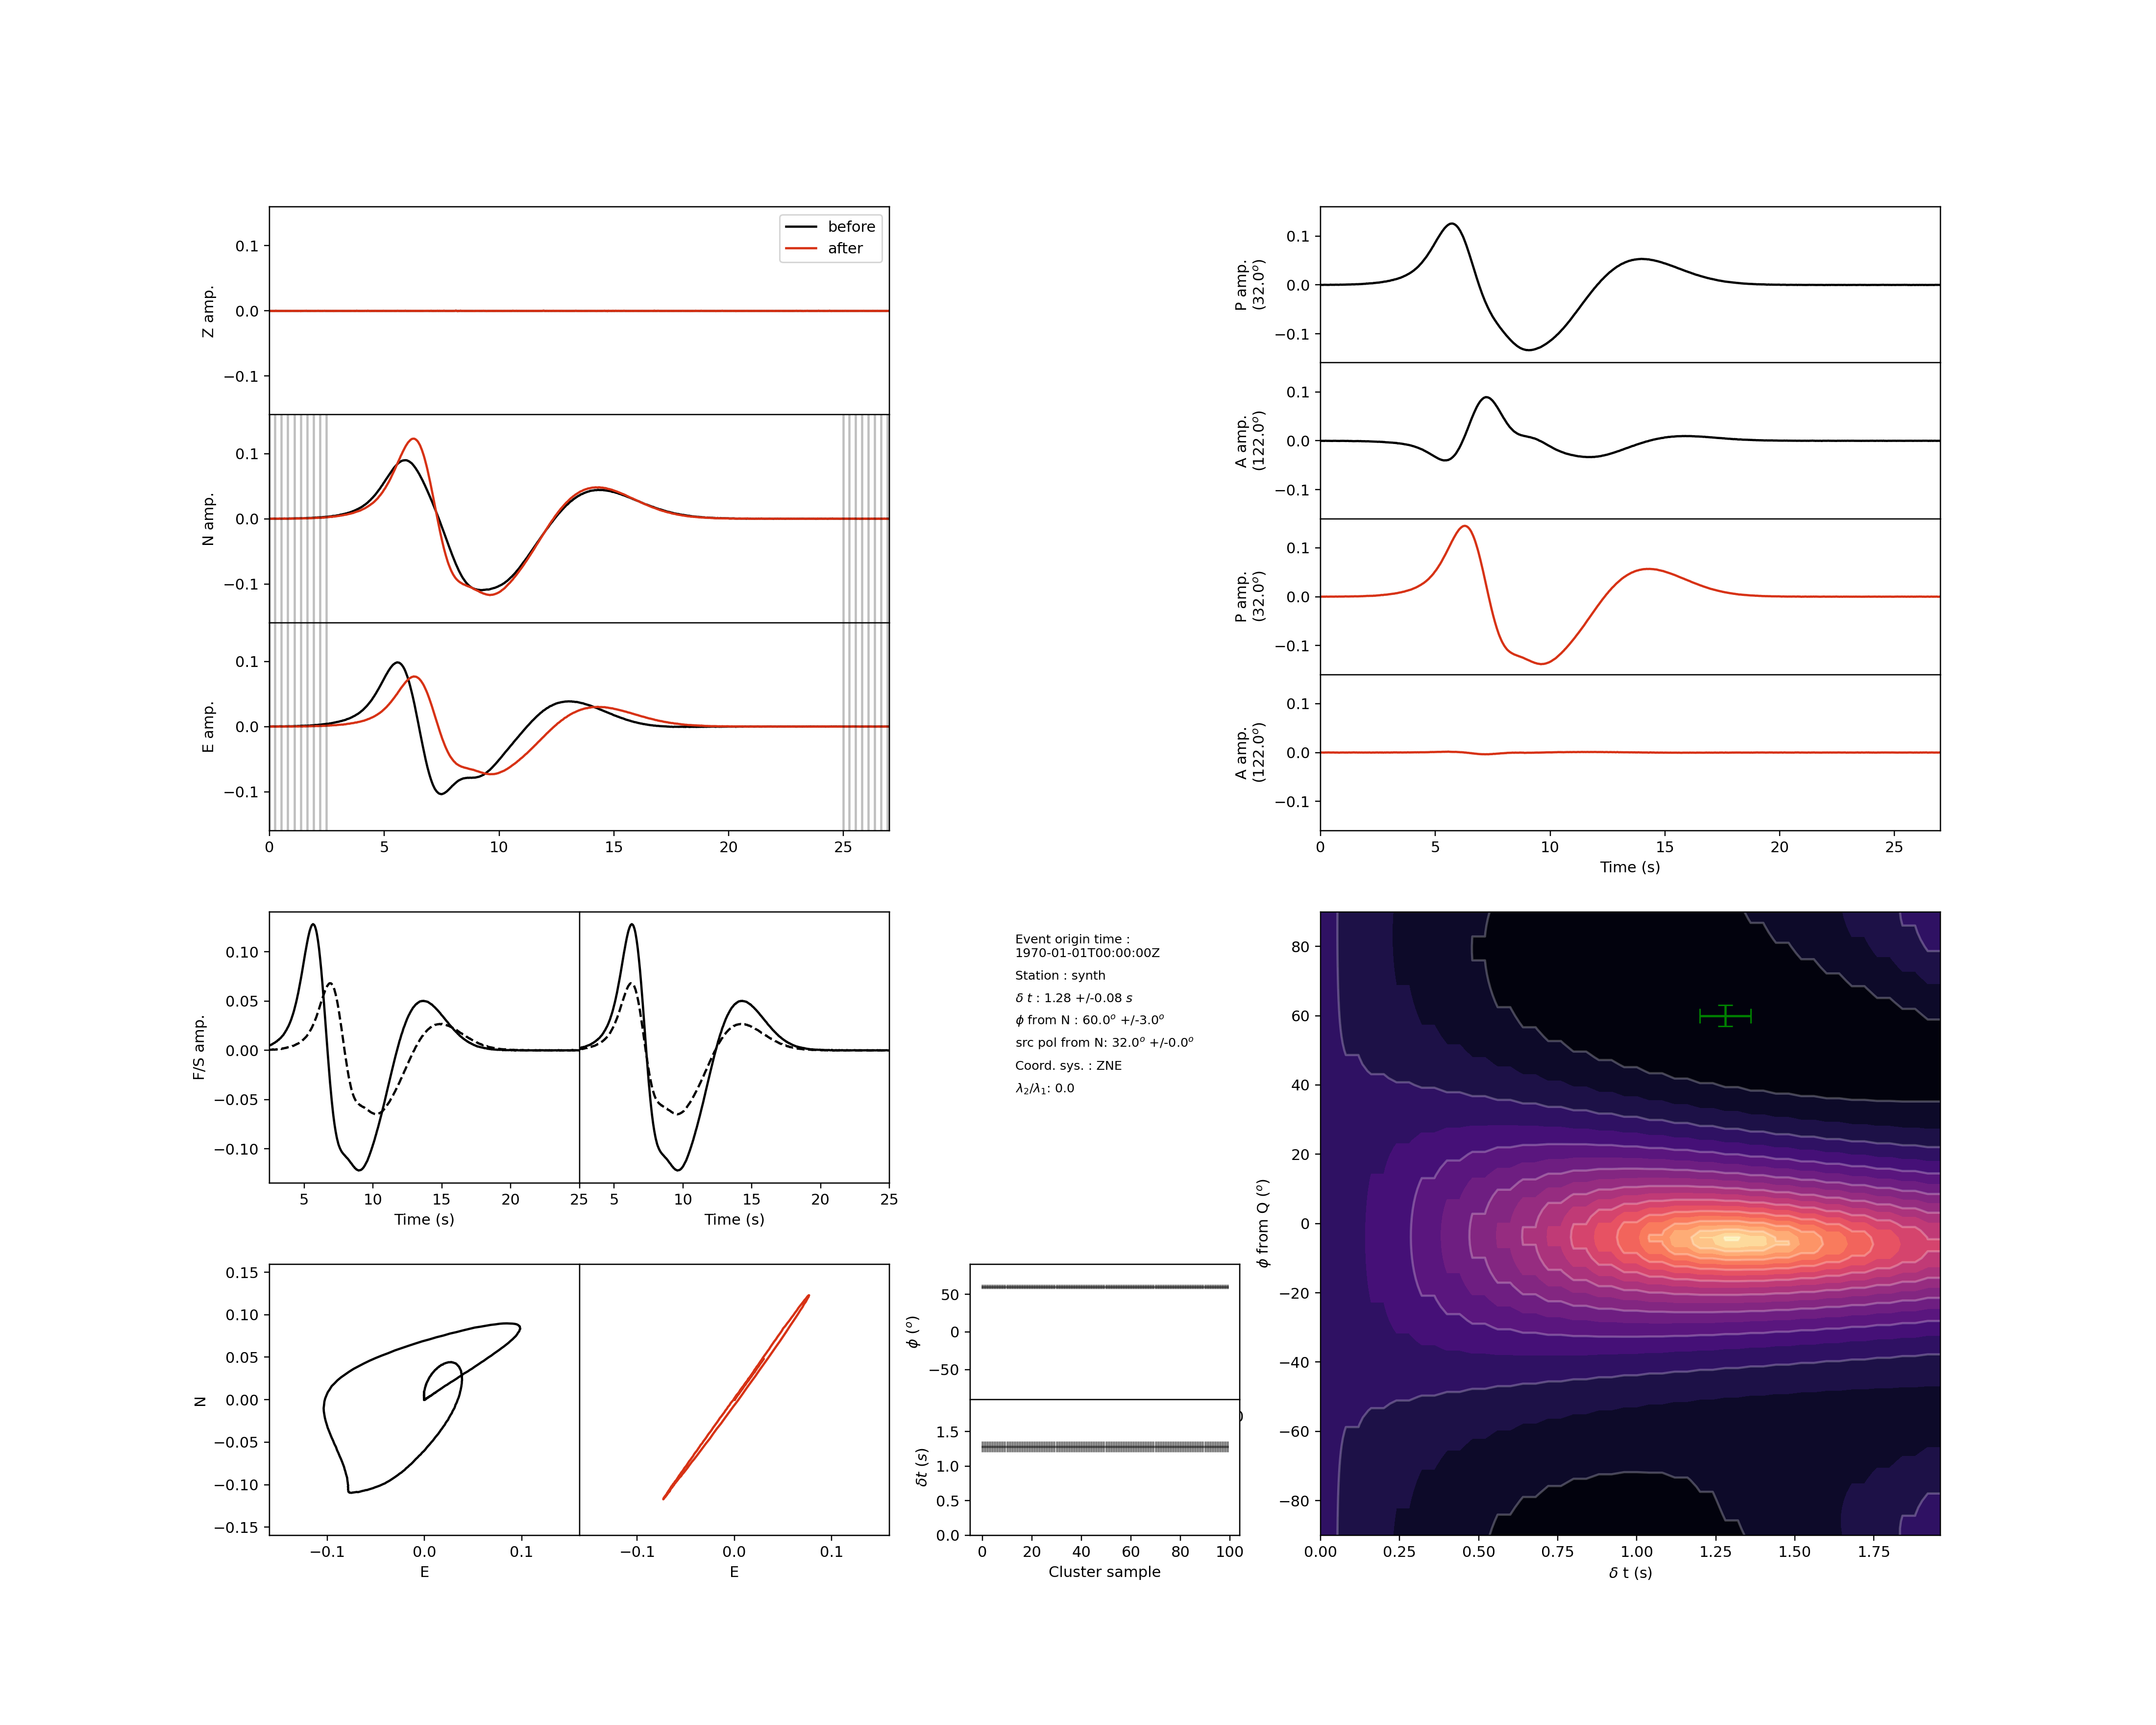

/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:2131: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(os.path.join(outdir, ''.join((self.event_uid, "_", station, ".png"))), dpi=300)


Saved sws result to: outputs/data/teleseismic_single-layer_sws_result.csv


In [7]:
# Measure splitting:
measure_single_splitting = True
if measure_single_splitting:
    event_uid = "teleseismic_single-layer"
    S_phase_arrival_times = [ZNE_st_layer1[0].stats.starttime+t_src]
    back_azis_all_stations = [back_azi]
    receiver_inc_angles_all_stations = [event_inclin_angle_at_station]
    splitting_event = swspy.splitting.create_splitting_object(ZNE_st_layer1, event_uid=event_uid, stations_in=["synth"], S_phase_arrival_times=S_phase_arrival_times, back_azis_all_stations=back_azis_all_stations, receiver_inc_angles_all_stations=receiver_inc_angles_all_stations) 
    splitting_event.overall_win_start_pre_fast_S_pick = 10
    splitting_event.win_S_pick_tolerance = 7.5
    splitting_event.overall_win_start_post_fast_S_pick = 15.0
    splitting_event.rotate_step_deg = 2 #1.0 
    splitting_event.max_t_shift_s = 2.0 #1.0
    splitting_event.n_win = 10 #10
    start_time = time.time()
    splitting_event.perform_sws_analysis(coord_system="ZNE", sws_method="EV")
    end_time = time.time()
    print("Time taken (s):", end_time-start_time)

    # And plot splitting result:
    splitting_event.plot(outdir=os.path.join("outputs", "plots"))

    # And save result to file:
    splitting_event.save_result(outdir=os.path.join("outputs", "data"))

## Multi-layer splitting

### 4. Apply a second layer of splitting:

<IPython.core.display.Javascript object>


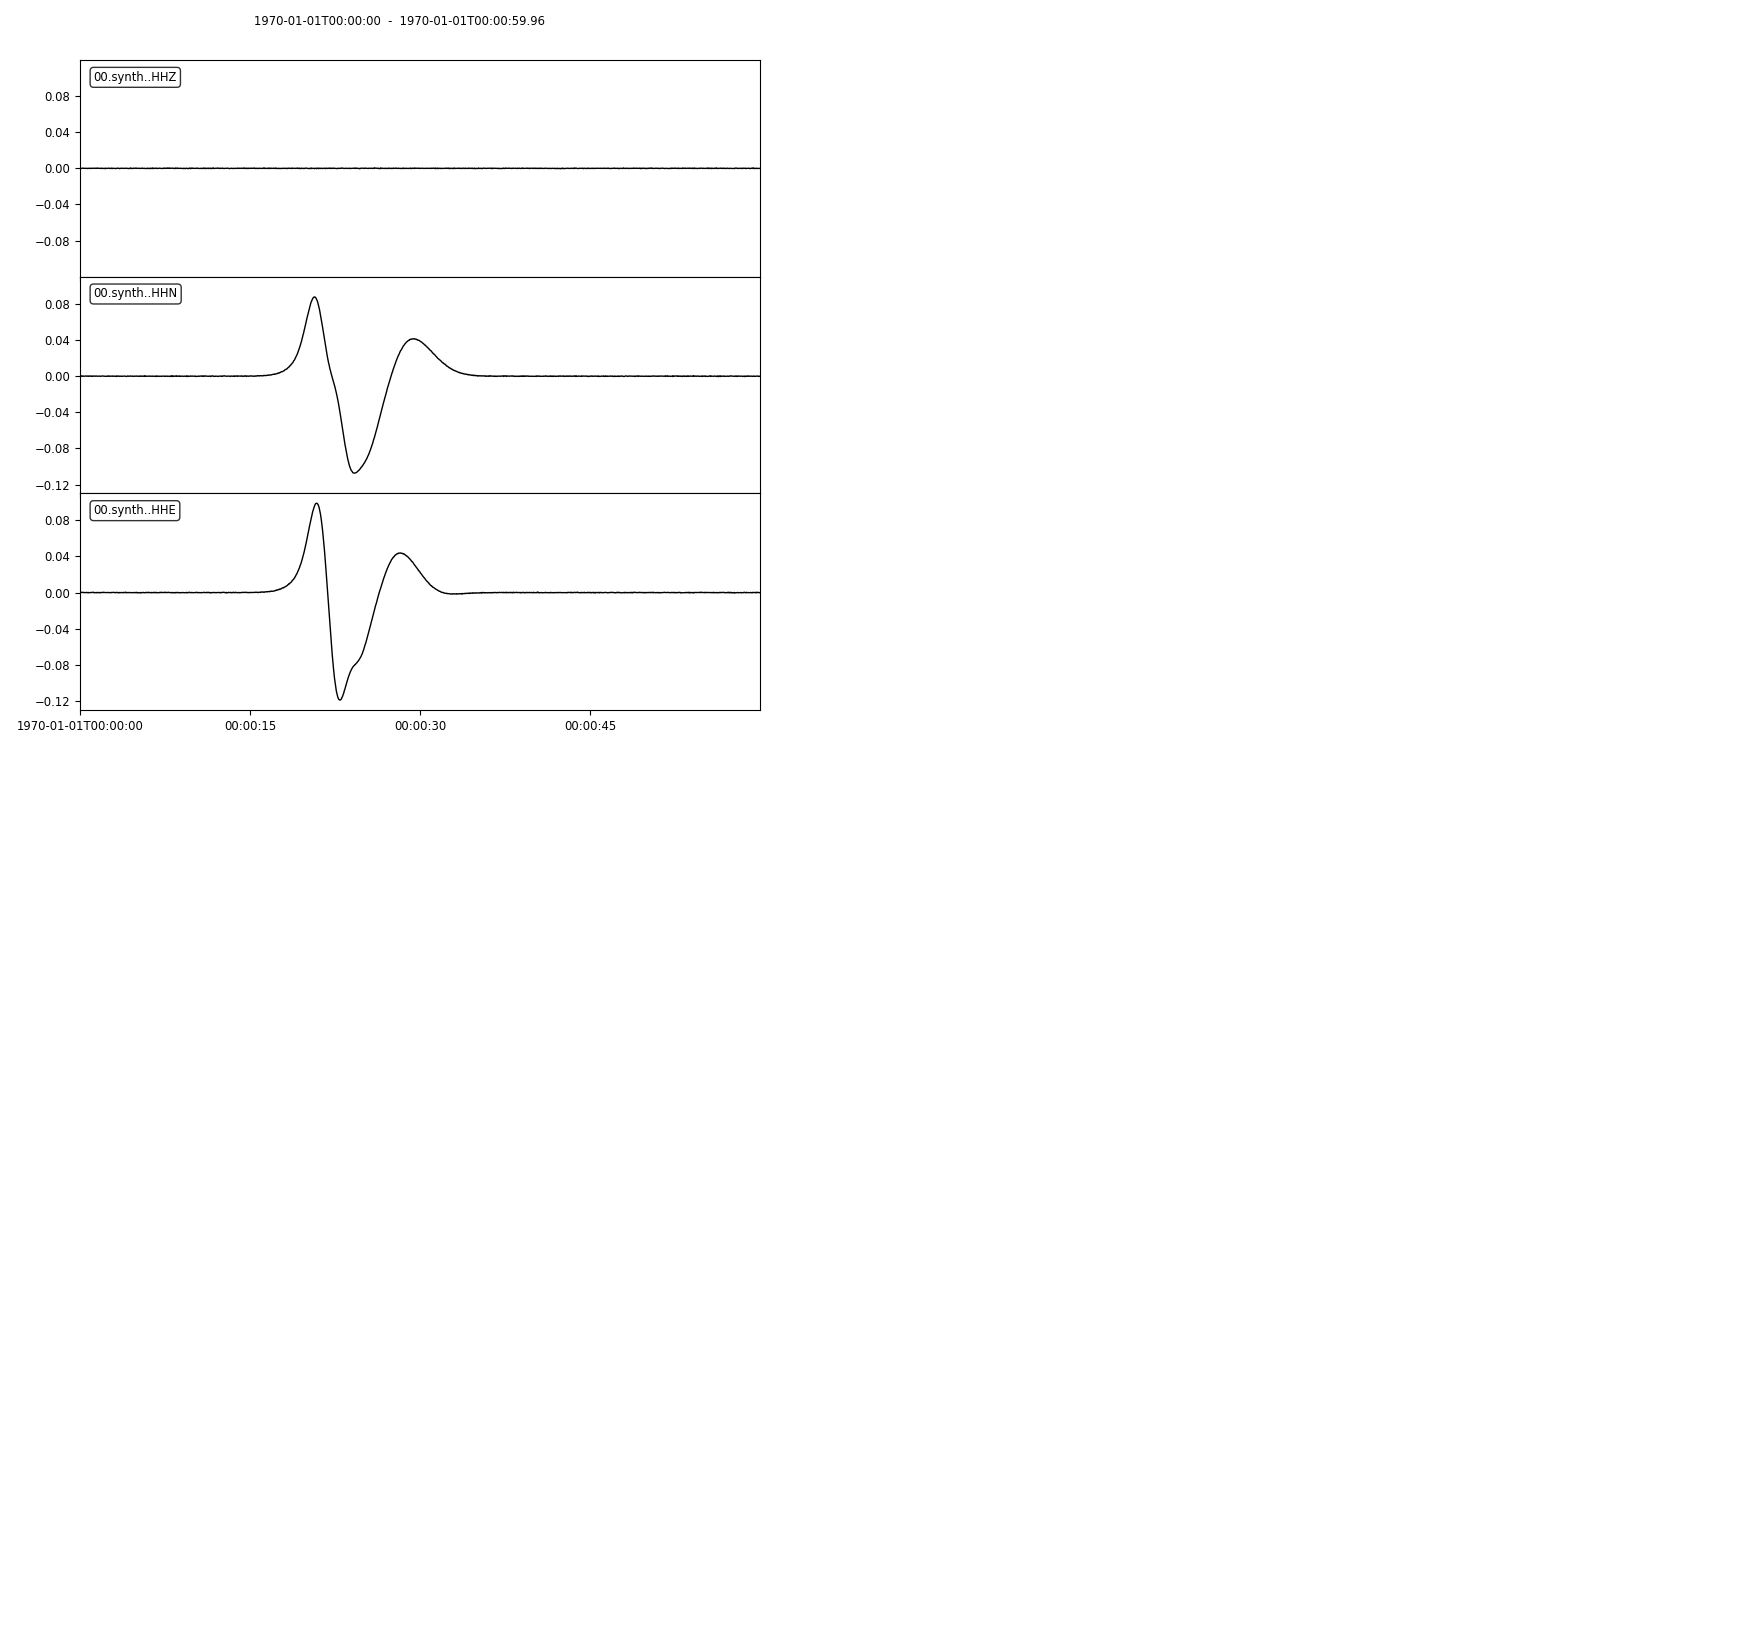

<IPython.core.display.Javascript object>


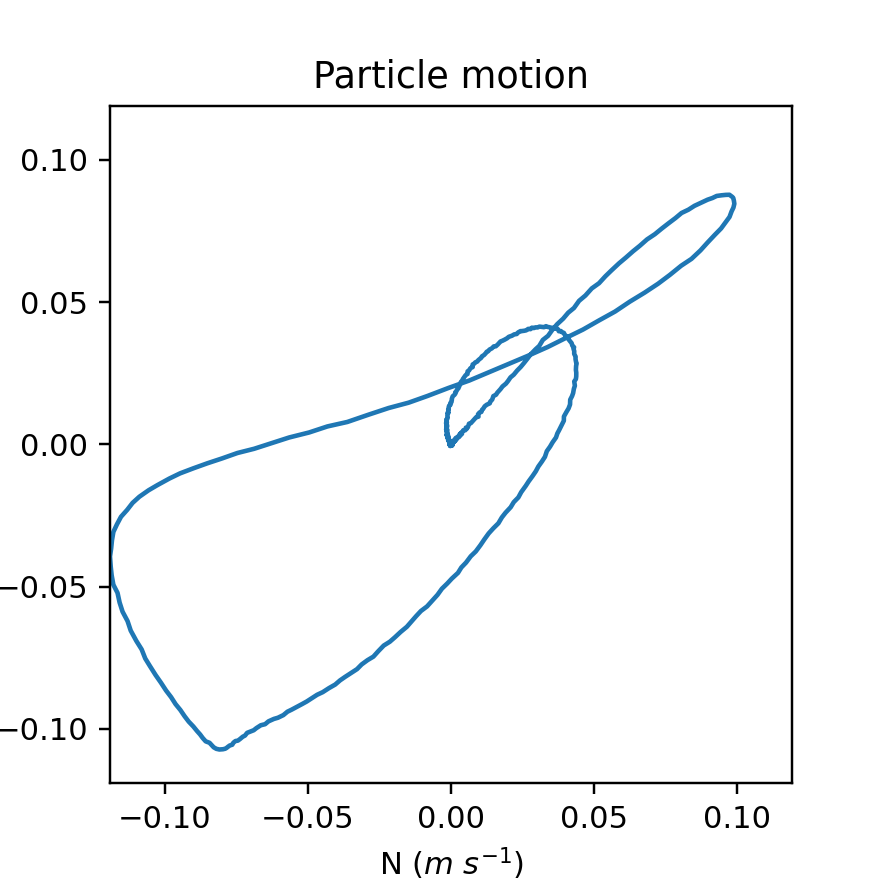

In [8]:
# Specify second layer parameters:
phi_from_N_layer2 = 25 #45 #40. #30
dt_layer2 = 0.5 #0.9 #0.5
# back_azi = 0
# event_inclin_angle_at_station = 0

# Apply splitting:
if create_synthetics:
    ZNE_st_layer1_no_noise = swspy.splitting.forward_model.add_splitting(ZNE_st, phi_from_N, dt, back_azi, event_inclin_angle_at_station, snr=snr) #, snr=snr*2)
    ZNE_st_layer1and2 = swspy.splitting.forward_model.add_splitting(ZNE_st_layer1_no_noise, phi_from_N_layer2, dt_layer2, back_azi, event_inclin_angle_at_station, snr=snr)
else:
    ZNE_st_layer1and2 = obspy.read(os.path.join("data", "teleseismic_ZNE_st_layer1and2.mseed"))
ZNE_st_layer1and2.plot()

plt.figure(figsize=(4,4))
plt.plot(ZNE_st_layer1and2.select(channel="??E")[0].data, ZNE_st_layer1and2.select(channel="??N")[0].data)
abs_max_tmp = np.max(np.array([np.max(np.abs(ZNE_st_layer1and2.select(channel="??N")[0].data)), np.max(np.abs(ZNE_st_layer1and2.select(channel="??E")[0].data))]))
plt.xlim([-abs_max_tmp, abs_max_tmp])
plt.ylim([-abs_max_tmp, abs_max_tmp])
plt.title("Particle motion")
plt.xlabel("E ($m$ $s^{-1}$)")
plt.xlabel("N ($m$ $s^{-1}$)")
plt.show()


### 5. And measure multi-layer splitting (using explicit method):

(Note: Important to start S-wave window as close to/before S-wave pick for this example)

Passed multi-layer result, therefore plotting this result.


<IPython.core.display.Javascript object>


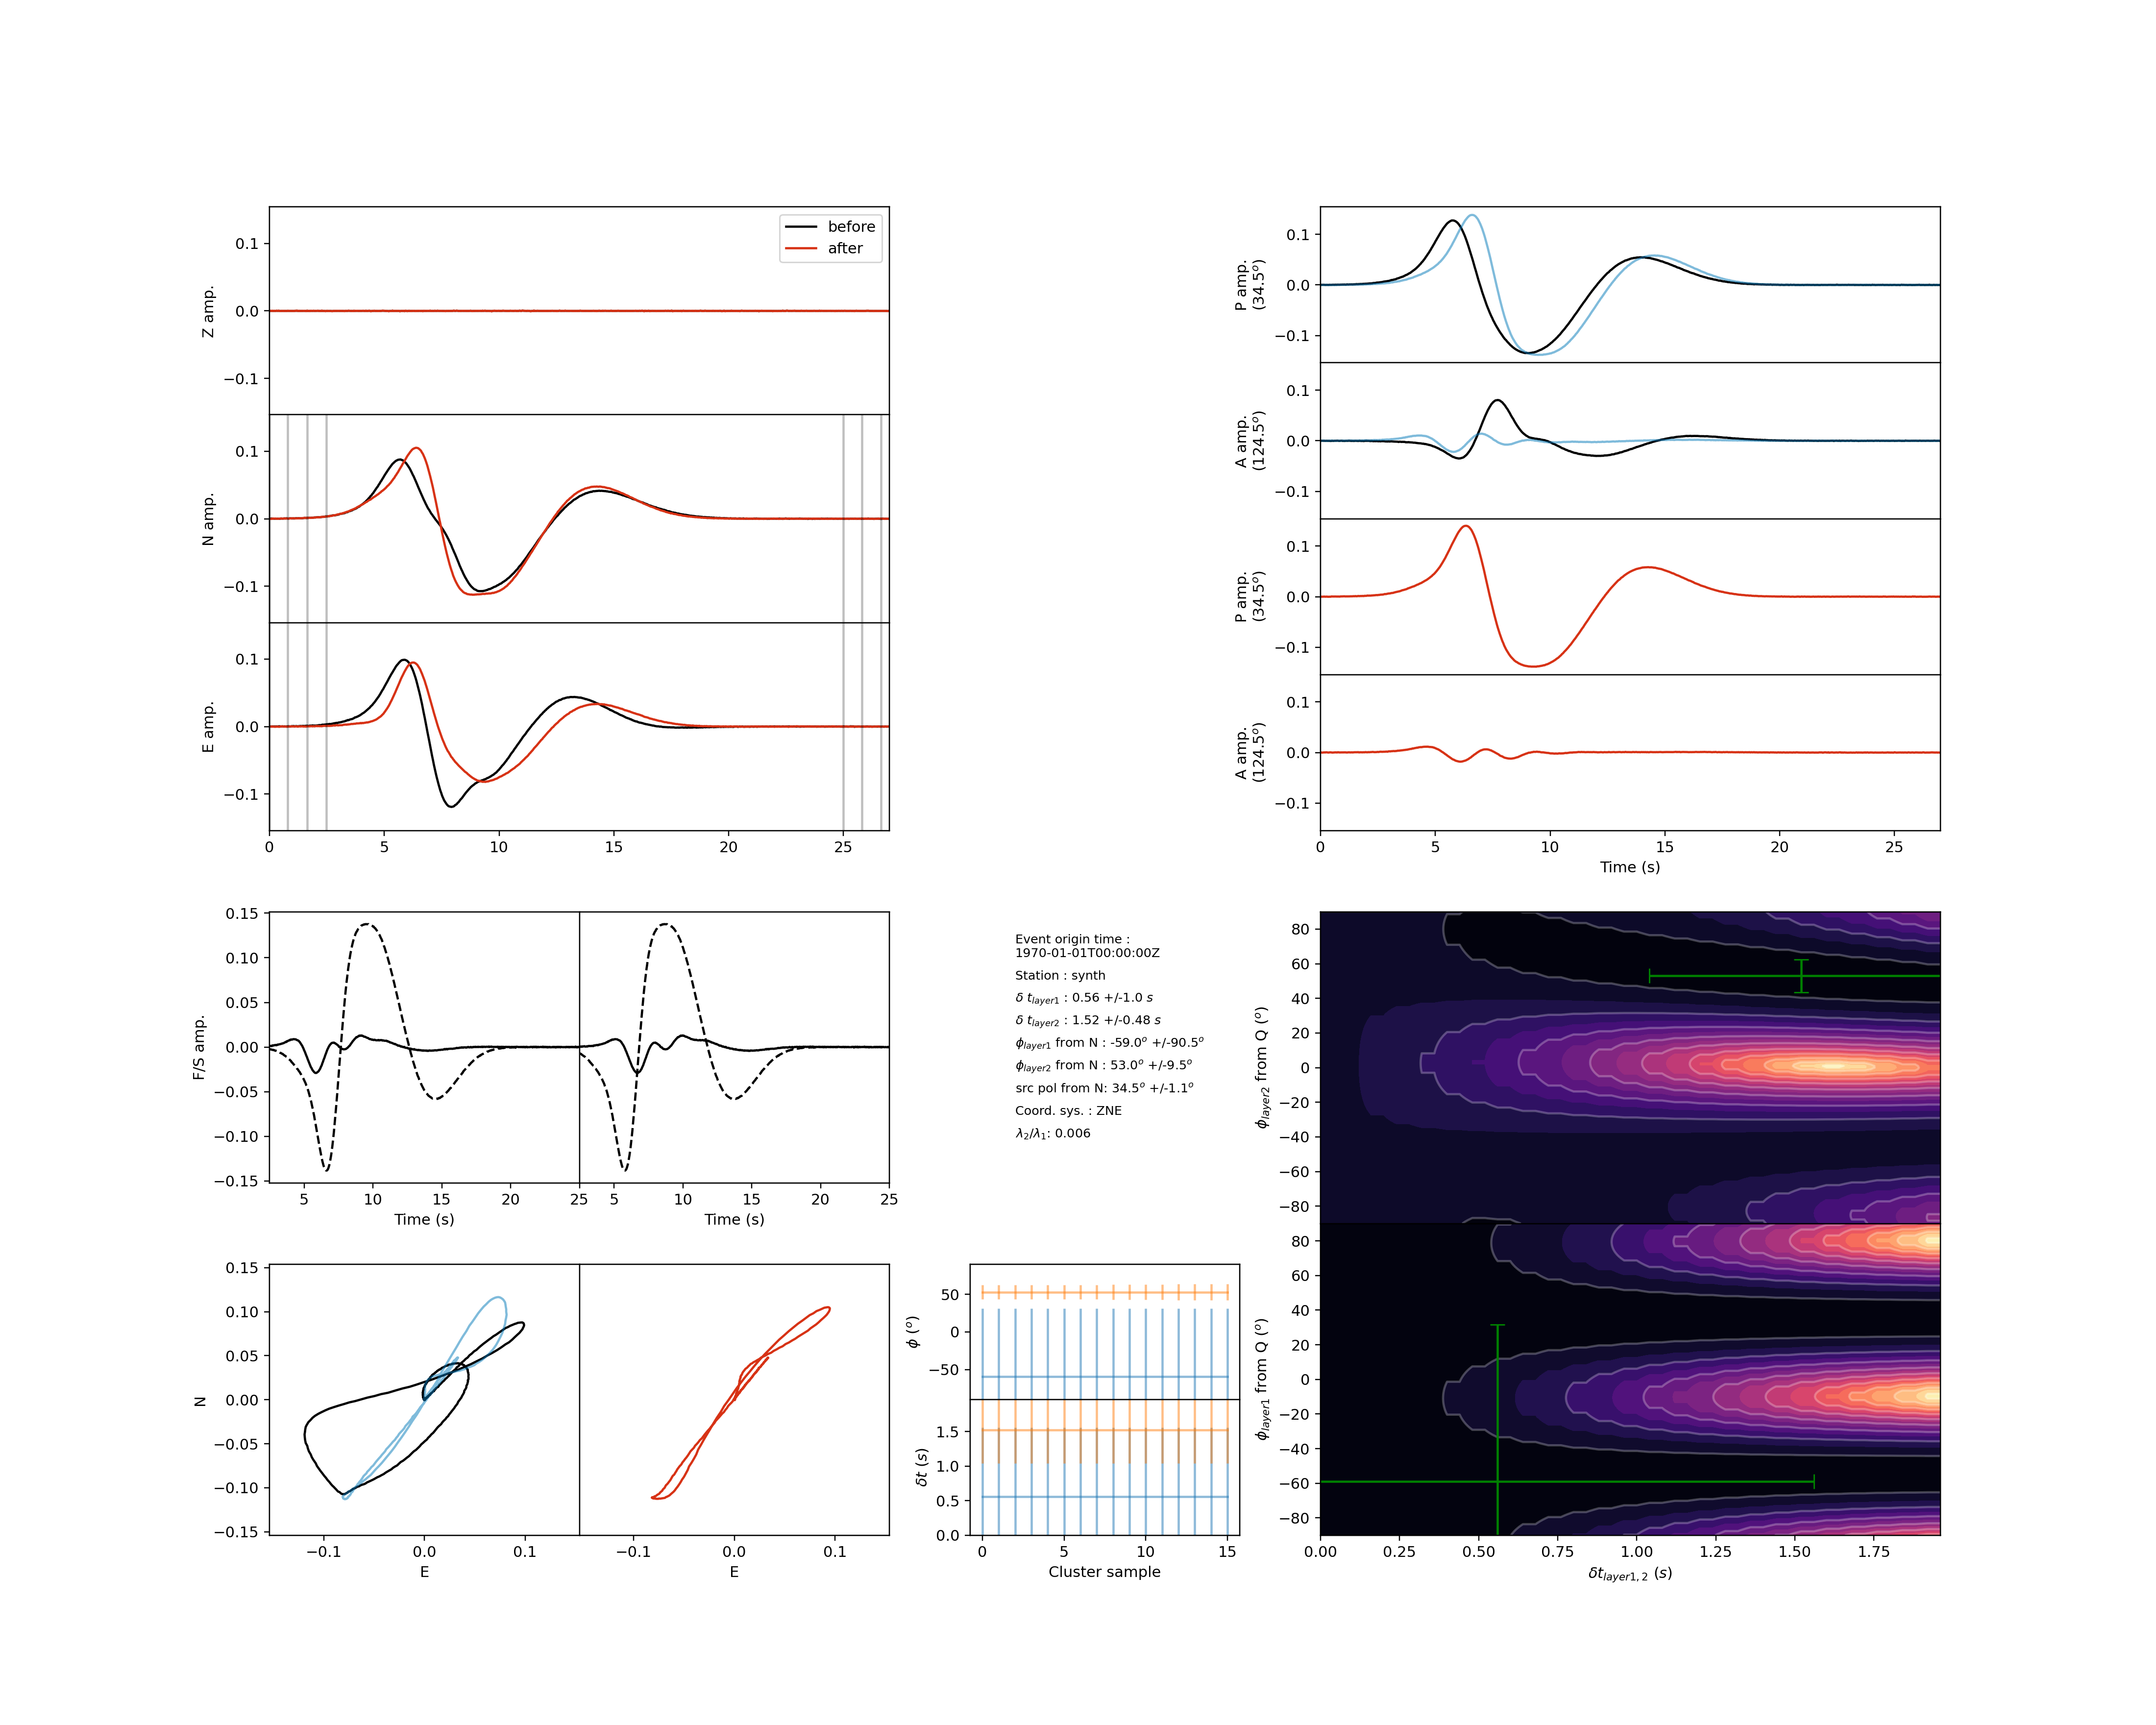

/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:2131: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(os.path.join(outdir, ''.join((self.event_uid, "_", station, ".png"))), dpi=300)


Saved sws result to: outputs/data/teleseismic_multi-layer_sws_result.csv


In [9]:
# Measure splitting for multi-layer:
measure_multi_layer_explicit_splitting = True
if measure_multi_layer_explicit_splitting:
    event_uid = "teleseismic_multi-layer"
    S_phase_arrival_times = [ZNE_st_layer1and2[0].stats.starttime+t_src]
    back_azis_all_stations = [back_azi]
    receiver_inc_angles_all_stations = [event_inclin_angle_at_station]
    splitting_event_multi_layer = swspy.splitting.create_splitting_object(ZNE_st_layer1and2, event_uid=event_uid, stations_in=["synth"], S_phase_arrival_times=S_phase_arrival_times, back_azis_all_stations=back_azis_all_stations, receiver_inc_angles_all_stations=receiver_inc_angles_all_stations) 
    splitting_event_multi_layer.overall_win_start_pre_fast_S_pick = 10
    splitting_event_multi_layer.win_S_pick_tolerance = 7.5
    splitting_event_multi_layer.overall_win_start_post_fast_S_pick = 15
    splitting_event_multi_layer.rotate_step_deg = 1 #2. 
    splitting_event_multi_layer.max_t_shift_s = 2 #3 #2 #2.5
    splitting_event_multi_layer.n_win = 4 #4 #10 
    splitting_event_multi_layer.perform_sws_analysis_multi_layer(coord_system="ZNE")

    # Plot and save result:
    splitting_event_multi_layer.plot(outdir=os.path.join("outputs", "plots"))
    splitting_event_multi_layer.save_result(outdir=os.path.join("outputs", "data"))

### 6. And measure multi-layer splitting (using direct method, for comparison):

Dom. freq. (Hz) used: 0.110946745562
--- Calculating multi-layer splitting pairs from apparent splitting parameters ---
1.56 56.0 0.12 -75.0


<IPython.core.display.Javascript object>


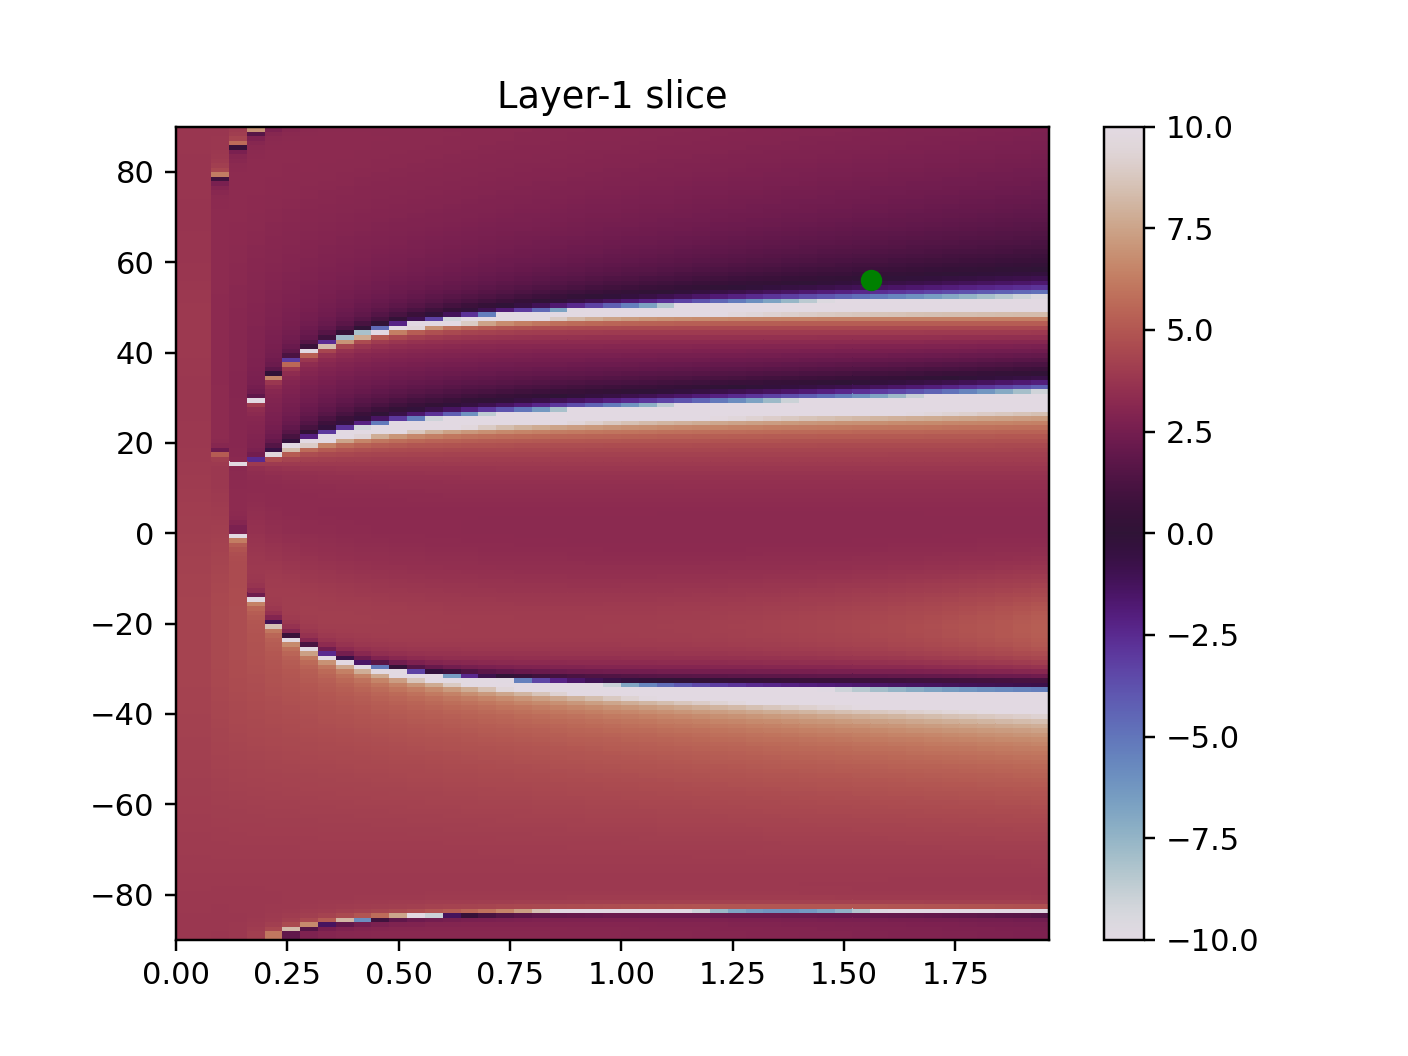

/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:682: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, diff_arr[:,:,min_indices[2], min_indices[3]], vmin=-10, vmax=10, cmap="twilight")


<IPython.core.display.Javascript object>


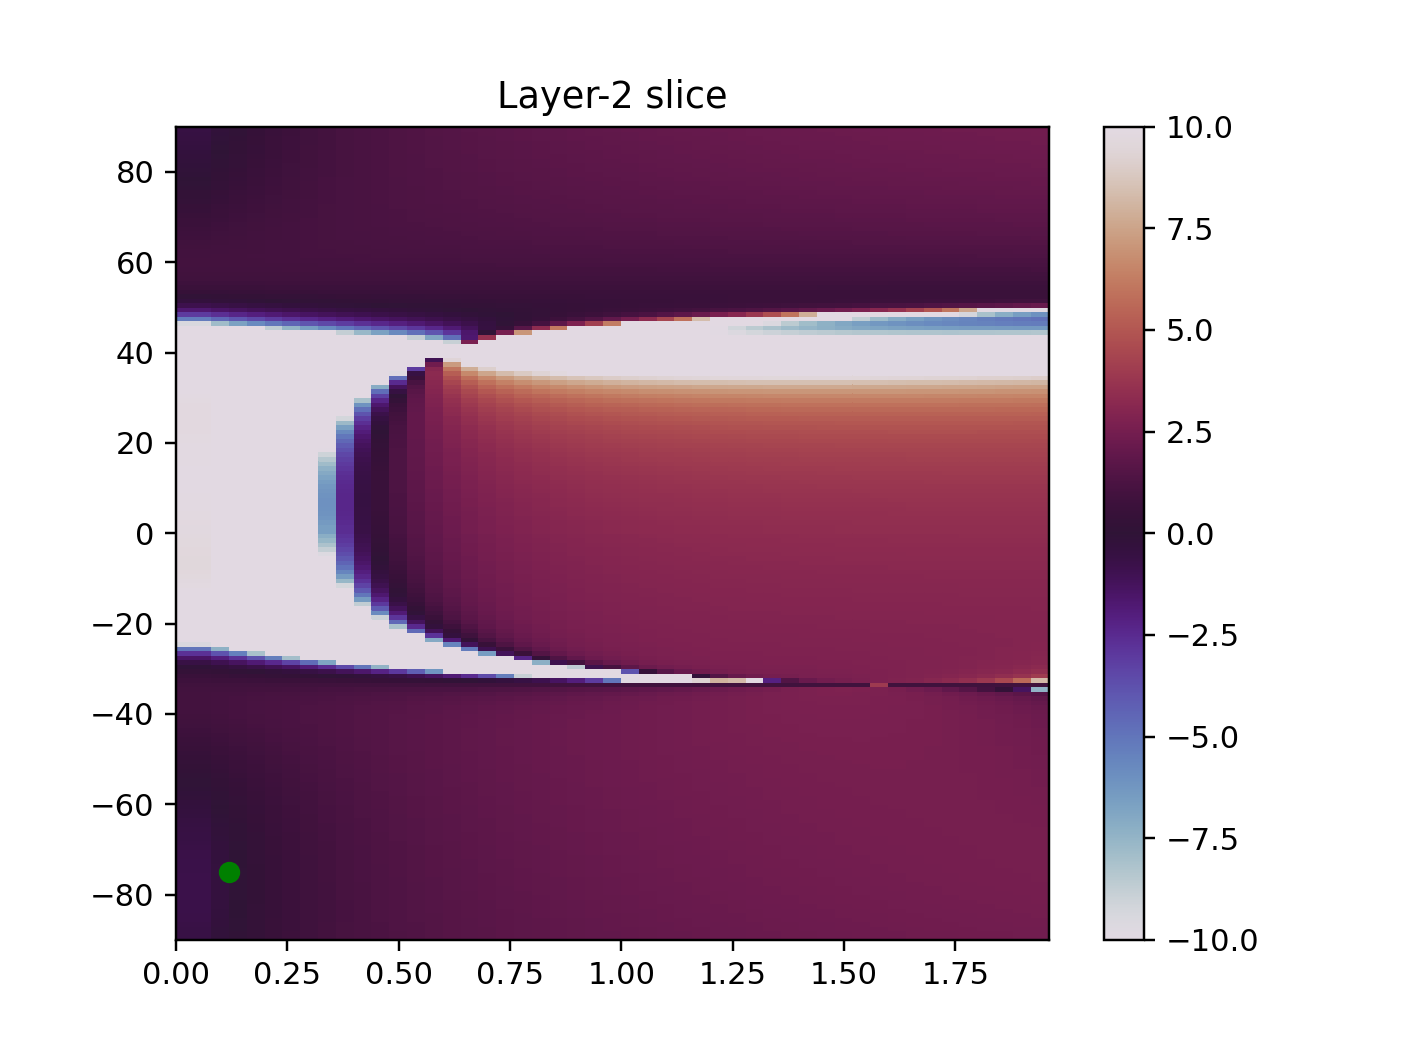

--- Finished calculating multi-layer splitting pairs from apparent splitting parameters ---


/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:688: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, diff_arr[min_indices[0], min_indices[1], :, :], vmin=-10, vmax=10, cmap="twilight")


Time taken (s): 6.984531879425049
Passed multi-layer result, therefore plotting this result.


<IPython.core.display.Javascript object>


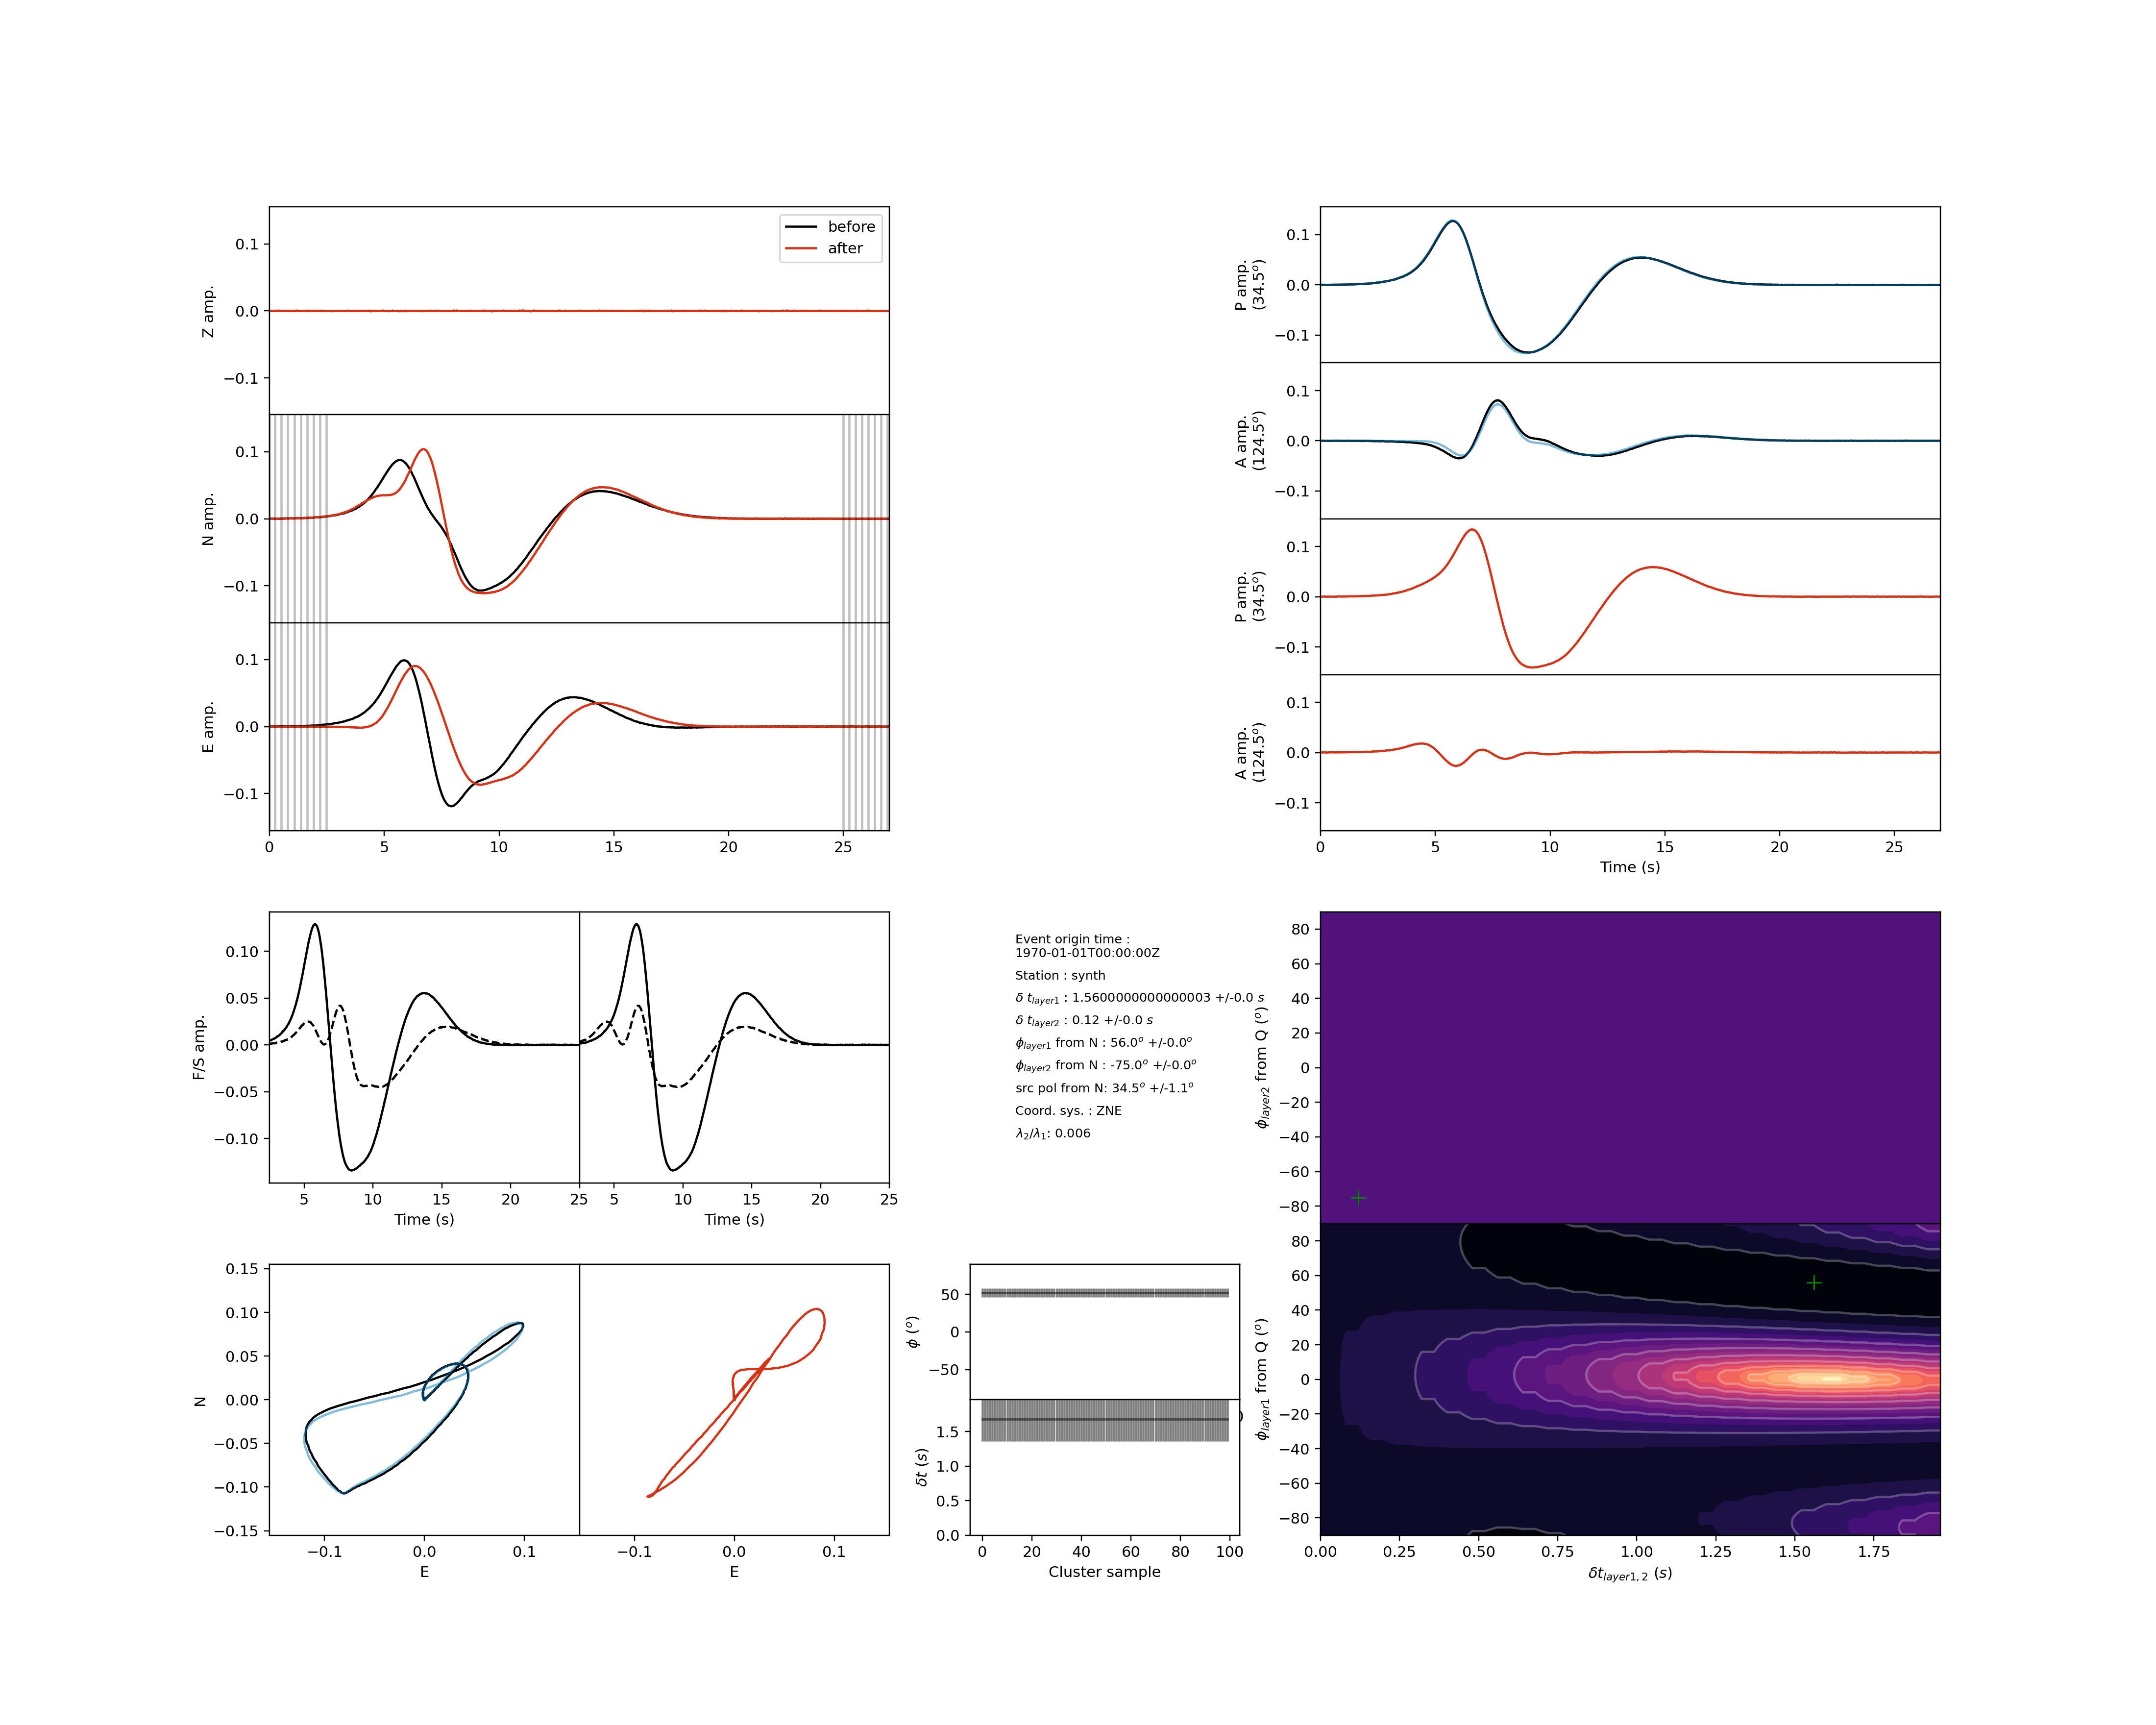

/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:2131: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(os.path.join(outdir, ''.join((self.event_uid, "_", station, ".png"))), dpi=300)


Saved sws result to: outputs/data/teleseismic_multi-layer_direct_method_sws_result.csv


In [10]:
# Measure splitting for multi-layer:
measure_multi_layer_direct_splitting = True #False
if measure_multi_layer_direct_splitting:
    event_uid = "teleseismic_multi-layer_direct_method"
    S_phase_arrival_times = [ZNE_st_layer1and2[0].stats.starttime+t_src]
    back_azis_all_stations = [back_azi]
    receiver_inc_angles_all_stations = [event_inclin_angle_at_station]
    splitting_event_multi_layer_direct_inv = swspy.splitting.create_splitting_object(ZNE_st_layer1and2, event_uid=event_uid, stations_in=["synth"], S_phase_arrival_times=S_phase_arrival_times, back_azis_all_stations=back_azis_all_stations, receiver_inc_angles_all_stations=receiver_inc_angles_all_stations) 
    splitting_event_multi_layer_direct_inv.overall_win_start_pre_fast_S_pick = 10 
    splitting_event_multi_layer_direct_inv.win_S_pick_tolerance = 7.5
    splitting_event_multi_layer_direct_inv.overall_win_start_post_fast_S_pick = 15 
    splitting_event_multi_layer_direct_inv.rotate_step_deg = 1
    splitting_event_multi_layer_direct_inv.max_t_shift_s = 2 #0.75 #0.7 #1.0 
    splitting_event_multi_layer_direct_inv.n_win = 10 #4 #10 #4 #10 #2 #10
    start_time = time.time()
    splitting_event_multi_layer_direct_inv.perform_sws_analysis_multi_layer(coord_system="ZNE", multi_layer_method="direct")
    end_time = time.time()
    print("Time taken (s):", end_time-start_time)

    # Plot and save result:
    splitting_event_multi_layer_direct_inv.plot(outdir=os.path.join("outputs", "plots"))
    splitting_event_multi_layer_direct_inv.save_result(outdir=os.path.join("outputs", "data"))


## And measure effective splitting, assuming single layer, for comparison:

<IPython.core.display.Javascript object>


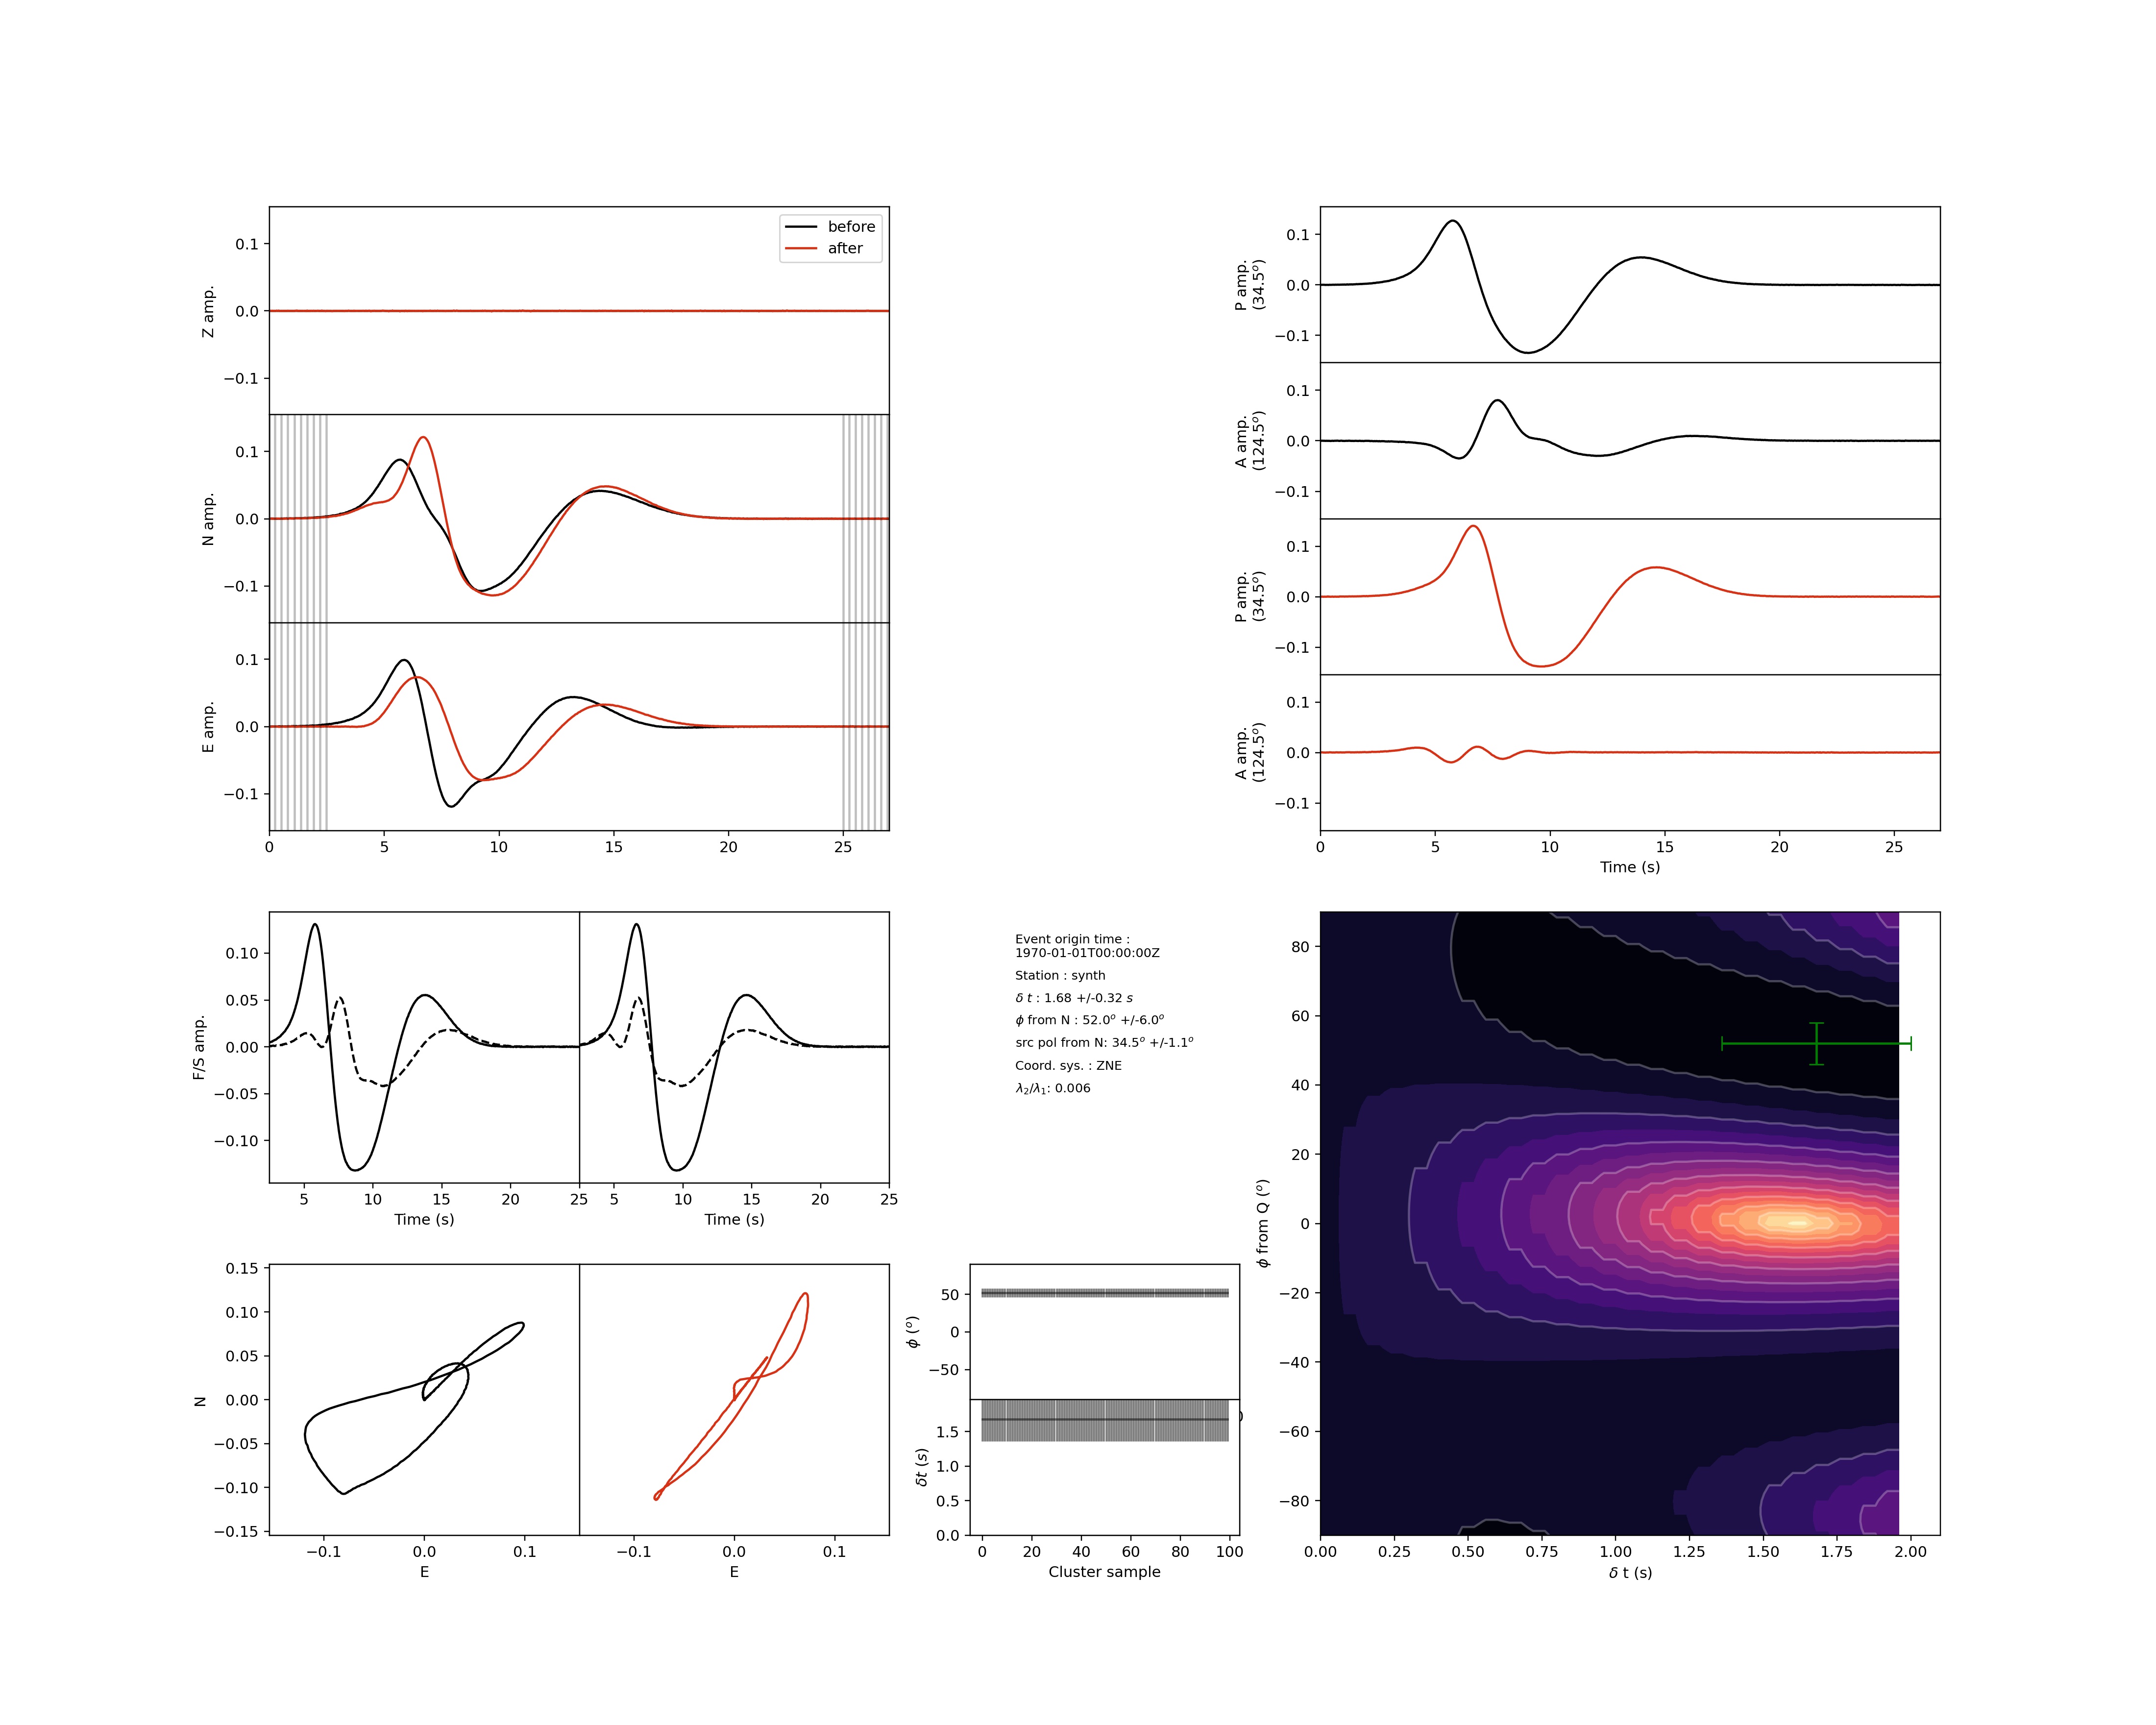

/Users/eart0504/Documents/python/github_repositories/swspy/swspy/splitting/split.py:2131: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  plt.savefig(os.path.join(outdir, ''.join((self.event_uid, "_", station, ".png"))), dpi=300)


Saved sws result to: outputs/data/teleseismic_multi-layer-effective_sws_result.csv


In [11]:
# Measure splitting:
measure_multi_layer_effective_splitting = True
if measure_multi_layer_effective_splitting:
    event_uid = "teleseismic_multi-layer-effective"
    S_phase_arrival_times = [ZNE_st_layer1and2[0].stats.starttime+t_src]
    back_azis_all_stations = [back_azi]
    receiver_inc_angles_all_stations = [event_inclin_angle_at_station]
    splitting_event = swspy.splitting.create_splitting_object(ZNE_st_layer1and2, event_uid=event_uid, stations_in=["synth"], S_phase_arrival_times=S_phase_arrival_times, back_azis_all_stations=back_azis_all_stations, receiver_inc_angles_all_stations=receiver_inc_angles_all_stations) 
    splitting_event.overall_win_start_pre_fast_S_pick = 10
    splitting_event.win_S_pick_tolerance = 7.5
    splitting_event.overall_win_start_post_fast_S_pick = 15
    splitting_event.rotate_step_deg = 2 #1.0
    splitting_event.max_t_shift_s = 2
    splitting_event.n_win = 10
    splitting_event.perform_sws_analysis(coord_system="ZNE", sws_method="EV")

    # And plot splitting result:
    splitting_event.plot(outdir=os.path.join("outputs", "plots"))

    # And save result to file:
    splitting_event.save_result(outdir=os.path.join("outputs", "data"))

In [12]:
# # Write data (for testing only!)
# ZNE_st.write(os.path.join("data", "teleseismic_ZNE_st.mseed"), format="MSEED")
# ZNE_st_layer1.write(os.path.join("data", "teleseismic_ZNE_st_layer1.mseed"), format="MSEED")
# ZNE_st_layer1and2.write(os.path.join("data", "teleseismic_ZNE_st_layer1and2.mseed"), format="MSEED")
